<a href="https://colab.research.google.com/github/neelsoumya/python_machine_learning/blob/main/logistic_regression_python_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EXAMPLE 1: BUTTERFLY PRESENCE ANALYSIS
Dataset shape: (500, 4)

First few rows:
   temperature   humidity  flower_density  butterfly_presence
0    24.483571  78.892663        1.833011                   0
1    21.308678  93.641250        1.104488                   0
2    25.238443  44.021486       10.117841                   0
3    29.615149  73.444539       12.257949                   0
4    20.829233  55.240361        0.320957                   1

Descriptive statistics:
       temperature    humidity  flower_density  butterfly_presence
count   500.000000  500.000000      500.000000          500.000000
mean     22.034190   65.477392       10.203172            0.190000
std       4.906266   14.669958       10.481216            0.392694
min       5.793663   24.546700        0.049522            0.000000
25%      18.498463   56.070624        2.728216            0.000000
50%      22.063986   65.427974        7.150330            0.000000
75%      25.183916   74.768634       13.337779        

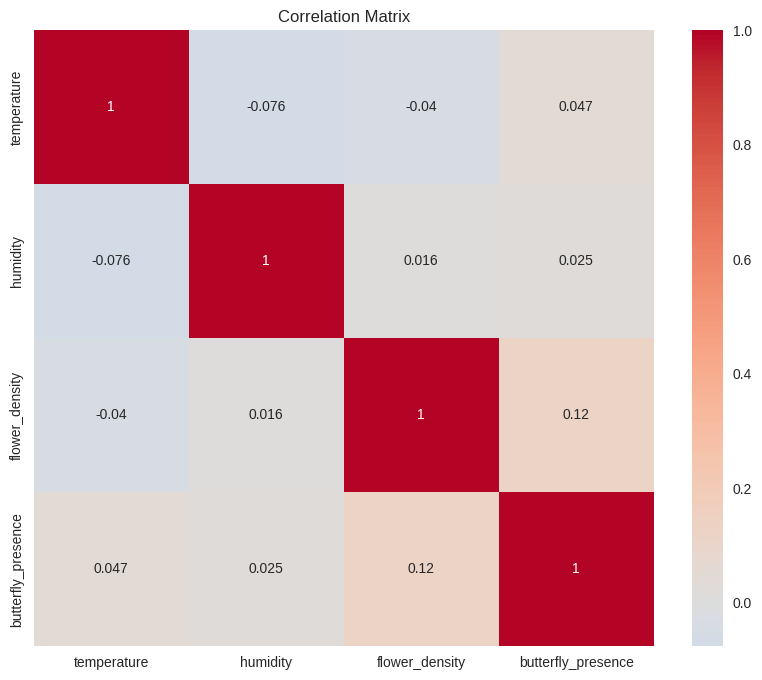


=== STATISTICAL SUMMARY ===
                           Logit Regression Results                           
Dep. Variable:     butterfly_presence   No. Observations:                  500
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Sep 2025   Pseudo R-squ.:                 0.01726
Time:                        17:09:15   Log-Likelihood:                -238.92
converged:                       True   LL-Null:                       -243.11
Covariance Type:            nonrobust   LLR p-value:                   0.03856
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7143      0.792     -3.427      0.001      -4.267      -1.162
temperature        0.0290      0.023      1.243      0.214      -0.017       0.075
humidit

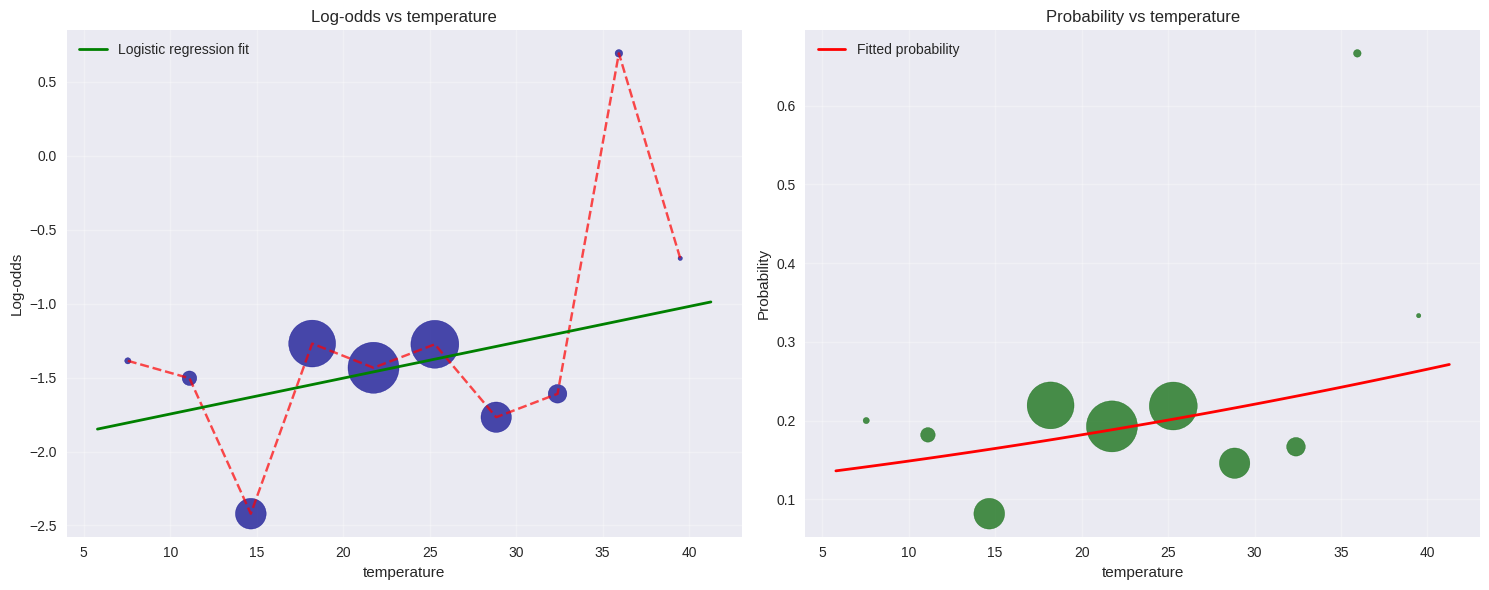

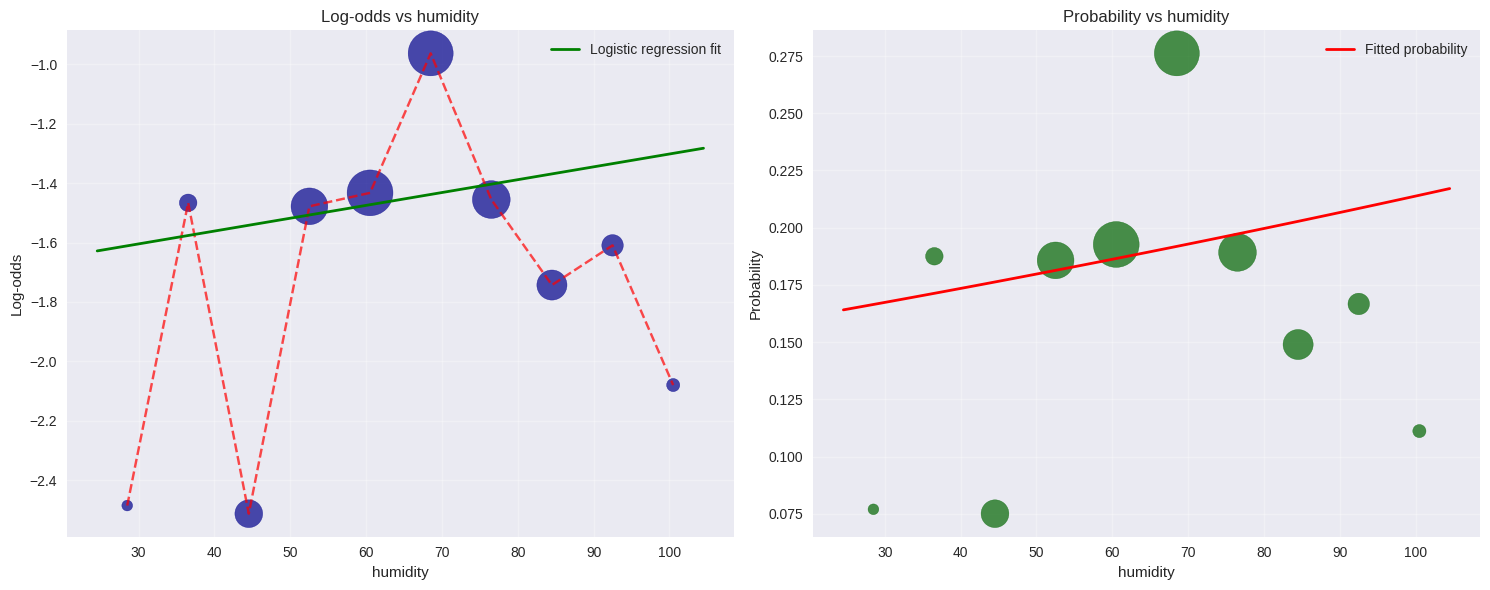

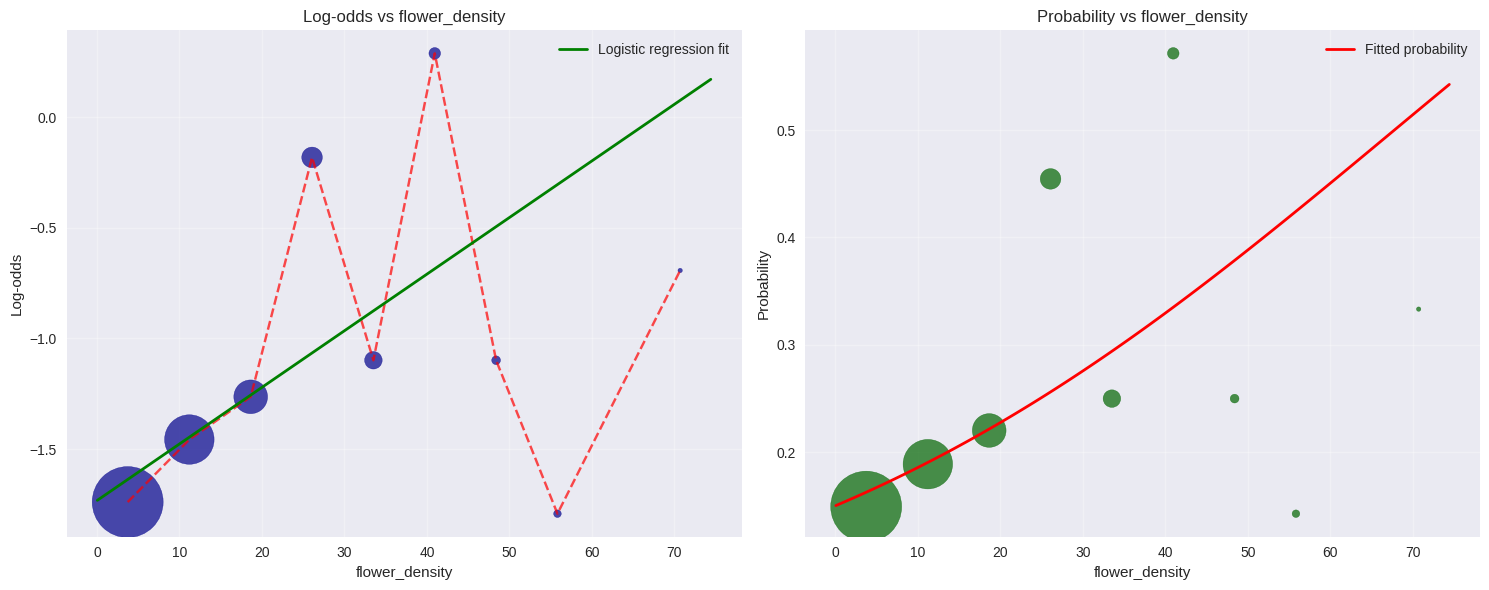

=== MODEL EVALUATION SUMMARY ===

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        80
           1       0.00      0.00      0.00        20

    accuracy                           0.80       100
   macro avg       0.40      0.50      0.44       100
weighted avg       0.64      0.80      0.71       100





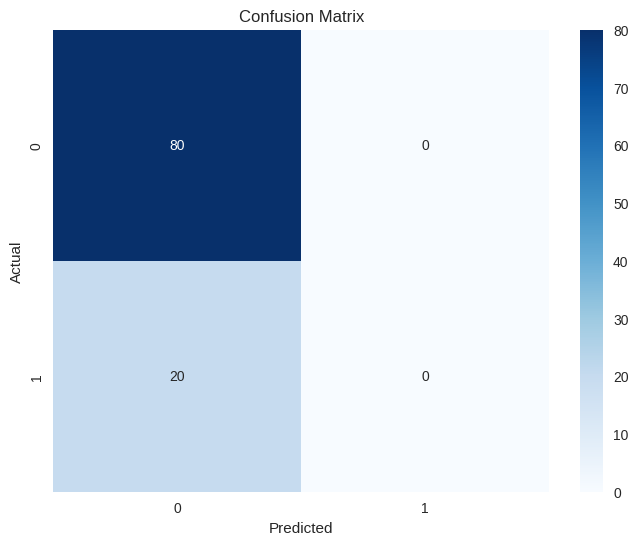

ROC-AUC Score: 0.5188


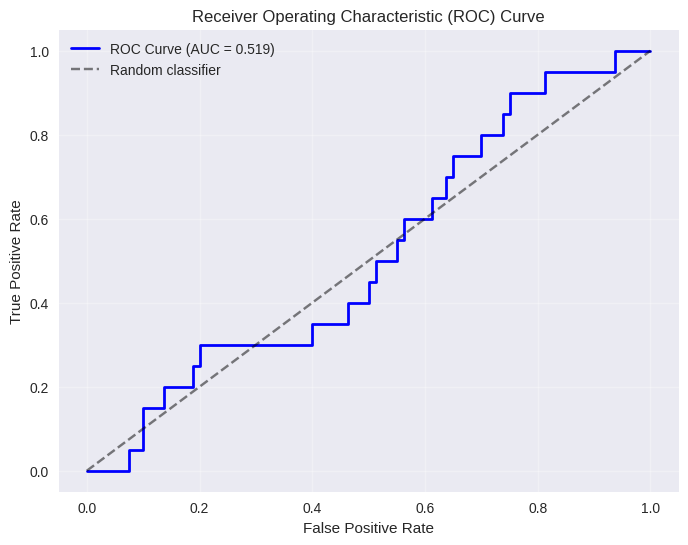



EXAMPLE 2: DISEASE PREDICTION ANALYSIS
Dataset shape: (300, 4)

Class distribution:
disease
1    194
0    106
Name: count, dtype: int64

=== STATISTICAL SUMMARY (Standardized Features) ===
                           Logit Regression Results                           
Dep. Variable:                disease   No. Observations:                  300
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Sep 2025   Pseudo R-squ.:                  0.1633
Time:                        17:09:18   Log-Likelihood:                -163.02
converged:                       True   LL-Null:                       -194.85
Covariance Type:            nonrobust   LLR p-value:                 9.788e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.77

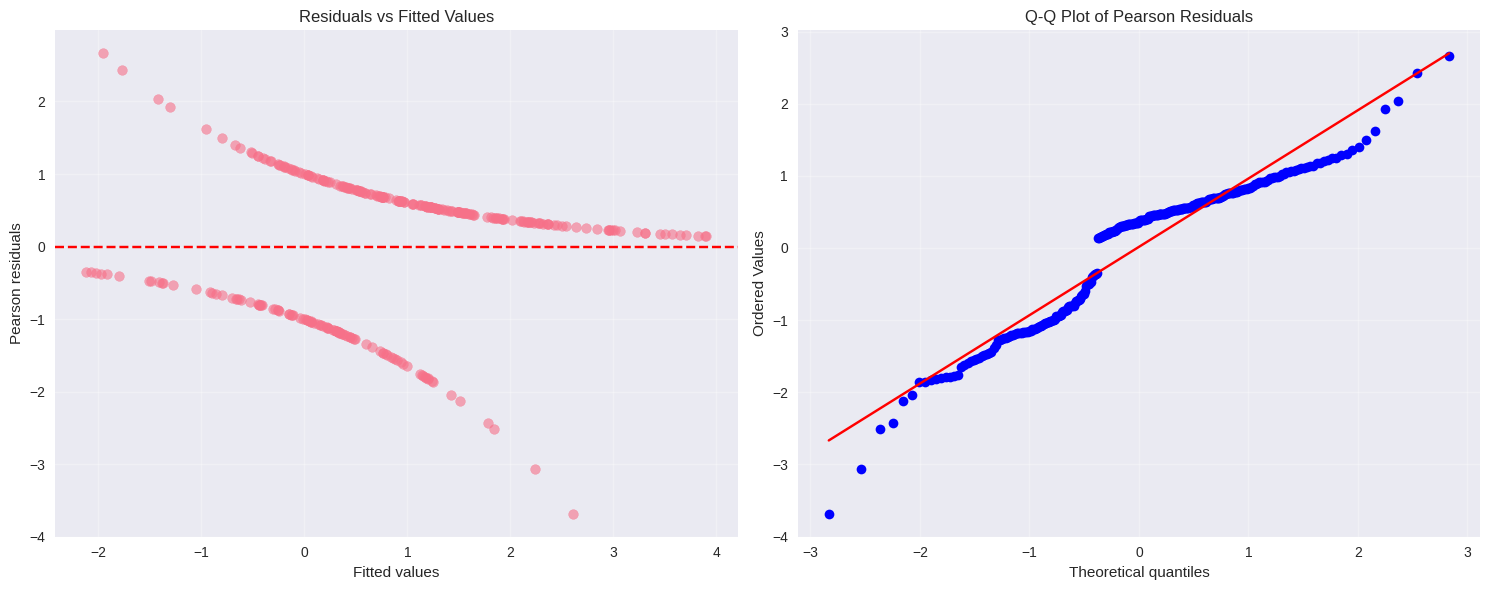



TEACHING EXERCISE: COEFFICIENT INTERPRETATION
Simple example: Predicting exam pass based on study hours
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Sep 2025   Pseudo R-squ.:                  0.1286
Time:                        17:09:19   Log-Likelihood:                -120.37
converged:                       True   LL-Null:                       -138.14
Covariance Type:            nonrobust   LLR p-value:                 2.499e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.0932      0.443     -4.723      0.000      -2.962      -1.225
study_hours     0.4694

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_curve, auc, roc_auc_score)
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ============================================================================
# 1. CREATE BIOLOGICAL EXAMPLE DATASETS
# ============================================================================

def create_butterfly_dataset(n_samples=500):
    """
    Create synthetic dataset: Predicting butterfly presence based on
    environmental factors
    """
    np.random.seed(42)

    # Environmental predictors
    temperature = np.random.normal(22, 5, n_samples)  # Temperature in Celsius
    humidity = np.random.normal(65, 15, n_samples)    # Humidity percentage
    flower_density = np.random.exponential(10, n_samples)  # Flowers per m²

    # Create probability based on realistic biological relationships
    # Butterflies prefer moderate temps, high humidity, high flower density
    temp_effect = -0.5 * (temperature - 25)**2 / 100  # Optimal around 25°C
    humidity_effect = 0.05 * humidity
    flower_effect = 0.3 * np.log(flower_density + 1)

    # Linear combination (log-odds)
    logits = -2 + temp_effect + humidity_effect * 0.02 + flower_effect

    # Convert to probabilities
    probabilities = 1 / (1 + np.exp(-logits))

    # Generate binary outcomes
    presence = np.random.binomial(1, probabilities, n_samples)

    return pd.DataFrame({
        'temperature': temperature,
        'humidity': humidity,
        'flower_density': flower_density,
        'butterfly_presence': presence
    })

def create_disease_dataset(n_samples=300):
    """
    Create synthetic medical dataset: Predicting disease based on biomarkers
    """
    np.random.seed(123)

    # Biomarkers
    age = np.random.normal(50, 15, n_samples)
    biomarker1 = np.random.normal(100, 20, n_samples)  # e.g., cholesterol
    biomarker2 = np.random.gamma(2, 2, n_samples)      # e.g., inflammation marker

    # Realistic disease probability
    logits = (-5 + 0.05 * age + 0.02 * biomarker1 + 0.3 * biomarker2 +
              np.random.normal(0, 0.5, n_samples))  # Add some noise

    probabilities = 1 / (1 + np.exp(-logits))
    disease = np.random.binomial(1, probabilities, n_samples)

    return pd.DataFrame({
        'age': age,
        'biomarker1': biomarker1,
        'biomarker2': biomarker2,
        'disease': disease
    })

# ============================================================================
# 2. BASIC LOGISTIC REGRESSION IMPLEMENTATION
# ============================================================================

class LogisticRegressionTeaching:
    """
    Educational logistic regression class with detailed outputs
    """

    def __init__(self):
        self.model = None
        self.results = None

    def fit(self, X, y, add_intercept=True):
        """Fit logistic regression with detailed statistical output"""
        if add_intercept:
            X = sm.add_constant(X)

        self.model = sm.Logit(y, X)
        self.results = self.model.fit(disp=False)

        return self

    def summary(self):
        """Print detailed statistical summary"""
        return self.results.summary()

    def predict_proba(self, X, add_intercept=True):
        """Predict probabilities"""
        if add_intercept:
            X = sm.add_constant(X)
        return self.results.predict(X)

    def get_odds_ratios(self):
        """Calculate and return odds ratios with confidence intervals"""
        params = self.results.params
        conf_int = self.results.conf_int()

        odds_ratios = np.exp(params)
        odds_conf_int = np.exp(conf_int)

        return pd.DataFrame({
            'Odds_Ratio': odds_ratios,
            'CI_Lower': odds_conf_int[0],
            'CI_Upper': odds_conf_int[1],
            'P_value': self.results.pvalues
        })

# ============================================================================
# 3. LOG-ODDS PLOTTING FUNCTIONS
# ============================================================================

def plot_logodds_single_predictor(X, y, predictor_name, bins=10):
    """
    Create log-odds plot for single predictor variable
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bin the predictor
    X_binned = pd.cut(X, bins=bins, include_lowest=True)
    bin_centers = []
    log_odds = []
    sample_sizes = []

    for bin_label in X_binned.cat.categories:
        mask = X_binned == bin_label
        if mask.sum() > 0:
            bin_center = (bin_label.left + bin_label.right) / 2
            n_success = y[mask].sum()
            n_total = mask.sum()
            n_failure = n_total - n_success

            # Add small constant to avoid log(0)
            if n_success == 0:
                n_success = 0.5
            if n_failure == 0:
                n_failure = 0.5

            odds = n_success / n_failure
            log_odd = np.log(odds)

            bin_centers.append(bin_center)
            log_odds.append(log_odd)
            sample_sizes.append(n_total)

    # Plot 1: Log-odds vs predictor
    ax1.scatter(bin_centers, log_odds, s=[n*10 for n in sample_sizes],
                alpha=0.7, c='darkblue')
    ax1.plot(bin_centers, log_odds, 'r--', alpha=0.7)
    ax1.set_xlabel(f'{predictor_name}')
    ax1.set_ylabel('Log-odds')
    ax1.set_title(f'Log-odds vs {predictor_name}')
    ax1.grid(True, alpha=0.3)

    # Add trend line using logistic regression
    X_smooth = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    lr = LogisticRegression()
    lr.fit(X.values.reshape(-1, 1), y)
    proba_smooth = lr.predict_proba(X_smooth)[:, 1]
    logodds_smooth = np.log(proba_smooth / (1 - proba_smooth))
    ax1.plot(X_smooth, logodds_smooth, 'g-', linewidth=2,
             label='Logistic regression fit')
    ax1.legend()

    # Plot 2: Probability vs predictor
    ax2.scatter(bin_centers, [1/(1+np.exp(-lo)) for lo in log_odds],
                s=[n*10 for n in sample_sizes], alpha=0.7, c='darkgreen')
    ax2.plot(X_smooth, proba_smooth, 'r-', linewidth=2,
             label='Fitted probability')
    ax2.set_xlabel(f'{predictor_name}')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Probability vs {predictor_name}')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    return fig

def plot_logodds_residuals(model_results, X):
    """
    Plot residuals for logistic regression
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Get fitted values and residuals
    fitted_values = model_results.fittedvalues
    residuals = model_results.resid_pearson

    # Plot 1: Residuals vs Fitted
    ax1.scatter(fitted_values, residuals, alpha=0.6)
    ax1.axhline(y=0, color='red', linestyle='--')
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Pearson residuals')
    ax1.set_title('Residuals vs Fitted Values')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Q-Q plot of residuals
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot of Pearson Residuals')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# ============================================================================
# 4. MODEL EVALUATION FUNCTIONS
# ============================================================================

def plot_roc_curve(y_true, y_proba):
    """Plot ROC curve with AUC"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'b-', linewidth=2,
             label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt.gcf()

def comprehensive_evaluation(y_true, y_pred, y_proba):
    """
    Comprehensive model evaluation with multiple metrics
    """
    print("=== MODEL EVALUATION SUMMARY ===\n")

    # Classification metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC
    auc_score = roc_auc_score(y_true, y_proba)
    print(f"ROC-AUC Score: {auc_score:.4f}")

    return auc_score

# ============================================================================
# 5. PRACTICAL EXAMPLES AND DEMONSTRATIONS
# ============================================================================

def example_1_butterfly_analysis():
    """
    Complete analysis of butterfly presence dataset
    """
    print("="*60)
    print("EXAMPLE 1: BUTTERFLY PRESENCE ANALYSIS")
    print("="*60)

    # Load data
    df = create_butterfly_dataset()
    print("Dataset shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())

    # Exploratory data analysis
    print("\nDescriptive statistics:")
    print(df.describe())

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

    # Prepare data for modeling
    X = df[['temperature', 'humidity', 'flower_density']]
    y = df['butterfly_presence']

    # Fit educational logistic regression
    lr_teach = LogisticRegressionTeaching()
    lr_teach.fit(X, y)

    print("\n=== STATISTICAL SUMMARY ===")
    print(lr_teach.summary())

    print("\n=== ODDS RATIOS ===")
    print(lr_teach.get_odds_ratios())

    # Create log-odds plots for each predictor
    for col in X.columns:
        fig = plot_logodds_single_predictor(X[col], y, col)
        plt.show()

    # Model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit sklearn model for evaluation
    lr_sklearn = LogisticRegression()
    lr_sklearn.fit(X_train, y_train)

    y_pred = lr_sklearn.predict(X_test)
    y_proba = lr_sklearn.predict_proba(X_test)[:, 1]

    # Comprehensive evaluation
    comprehensive_evaluation(y_test, y_pred, y_proba)

    # ROC curve
    fig = plot_roc_curve(y_test, y_proba)
    plt.show()

def example_2_disease_analysis():
    """
    Complete analysis of disease prediction dataset
    """
    print("="*60)
    print("EXAMPLE 2: DISEASE PREDICTION ANALYSIS")
    print("="*60)

    # Load data
    df = create_disease_dataset()
    print("Dataset shape:", df.shape)
    print("\nClass distribution:")
    print(df['disease'].value_counts())

    # Prepare data
    X = df[['age', 'biomarker1', 'biomarker2']]
    y = df['disease']

    # Standardize features (important for interpretation)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Fit model
    lr_teach = LogisticRegressionTeaching()
    lr_teach.fit(X_scaled, y)

    print("\n=== STATISTICAL SUMMARY (Standardized Features) ===")
    print(lr_teach.summary())

    print("\n=== ODDS RATIOS (per 1 SD increase) ===")
    print(lr_teach.get_odds_ratios())

    # Model diagnostics
    fig = plot_logodds_residuals(lr_teach.results, X_scaled)
    plt.show()

# ============================================================================
# 6. INTERACTIVE TEACHING EXERCISES
# ============================================================================

def teaching_exercise_coefficient_interpretation():
    """
    Interactive exercise for coefficient interpretation
    """
    print("="*60)
    print("TEACHING EXERCISE: COEFFICIENT INTERPRETATION")
    print("="*60)

    # Simple example with clear interpretation
    np.random.seed(100)
    n = 200

    # Single predictor: study hours
    study_hours = np.random.normal(5, 2, n)

    # Realistic relationship: more study = higher pass probability
    logits = -2 + 0.5 * study_hours + np.random.normal(0, 0.3, n)
    probabilities = 1 / (1 + np.exp(-logits))
    passed = np.random.binomial(1, probabilities, n)

    # Fit model
    X = pd.DataFrame({'study_hours': study_hours})
    y = pd.Series(passed)

    lr = LogisticRegressionTeaching()
    lr.fit(X, y)

    print("Simple example: Predicting exam pass based on study hours")
    print(lr.summary())

    # Interpretation guide
    coeff = lr.results.params['study_hours']
    odds_ratio = np.exp(coeff)

    print(f"\nINTERPRETATION:")
    print(f"Coefficient for study_hours: {coeff:.3f}")
    print(f"Odds ratio: {odds_ratio:.3f}")
    print(f"Interpretation: For each additional hour of study,")
    print(f"the odds of passing increase by a factor of {odds_ratio:.3f}")
    print(f"(or increase by {(odds_ratio-1)*100:.1f}%)")

    # Probability interpretation
    print(f"\nPROBABILITY EXAMPLES:")
    for hours in [2, 4, 6, 8]:
        prob = 1 / (1 + np.exp(-(lr.results.params['const'] + coeff * hours)))
        print(f"Study {hours} hours: {prob:.1%} probability of passing")

# ============================================================================
# 7. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run all examples
    example_1_butterfly_analysis()
    print("\n" + "="*80 + "\n")

    example_2_disease_analysis()
    print("\n" + "="*80 + "\n")

    teaching_exercise_coefficient_interpretation()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)